<a href="https://colab.research.google.com/github/BasemRizk/Data-Analysis-Visualization/blob/main/OCR_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
#Import the needed dependincies
import os
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import numpy as np
import cv2
from skimage import io, exposure
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dropout, Dense
from keras.utils import to_categorical
import tensorflow as tf
from keras.models import save_model

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set the name of our new directory
IMAGE_DIR='images'
# Set the path where we want to create the new directory
path = "/content/drive/My Drive/" + IMAGE_DIR
# Create the directory
os.makedirs(path, exist_ok=True)

In [5]:
#Place all images in one folder
new_dir = '/content/drive/MyDrive/images'
for i in range(0,10):
  current_dir = f'/content/drive/MyDrive/freelance/OCR_Task_Digits_Dataset/dataset/{i}'
  for filename in os.listdir(current_dir):
      if filename.endswith('.png'):
          old_path = os.path.join(current_dir, filename)
          new_path = os.path.join(new_dir, filename)
          shutil.move(old_path, new_path)

In [6]:
#Define the dir_path and img_size
dir_path = '/content/drive/MyDrive/images'
img_size = (28, 28)

In [7]:
#Labeling our images
file_names = os.listdir(dir_path)
label_dict = {}
for file_name in file_names:
    if file_name.endswith('.png'):
        label = file_name.split('_')[0]
        label_dict[file_name] = label

In [8]:
#Resize Images and convert to np.array
images = []
labels = []

for file_name in file_names:
    if file_name.endswith('.png'):
        file_path = os.path.join(dir_path, file_name)
        image = Image.open(file_path)
        image = image.resize(img_size)
        image = np.array(image)
        images.append(image)
        #listing our labels
        labels.append(label_dict[file_name])

In [9]:
print(images[0].shape)


(28, 28, 4)


In [10]:
#Convert labels from str to  integers
label=[]
for l in labels:
  label.append(int(l))
#convert images and labels lists to np.array
images = np.array(images)
label = np.array(label)

In [11]:
#Plot random images from our dataset
indices = np.random.choice(range(len(images)), replace=False, size=9)
selected_images = images[indices]

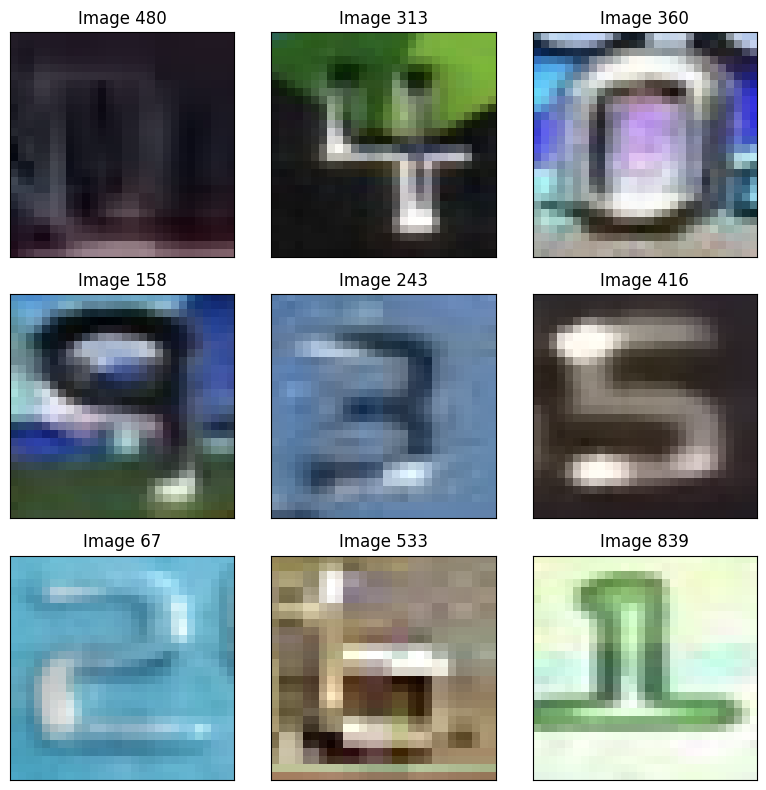

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(selected_images[i])
    ax.set_title(f"Image {indices[i]}")

plt.tight_layout()
plt.show()

In [13]:
for i in indices:
  print('Image',i ,'Label',label[i])

Image 480 Label 0
Image 313 Label 4
Image 360 Label 0
Image 158 Label 9
Image 243 Label 3
Image 416 Label 5
Image 67 Label 2
Image 533 Label 6
Image 839 Label 1


PreProcessing

In [14]:
# Convert the BGRA image to grayscale
Gray_Images=[]
for img in images:
  bgra_img=img
  gray_img = cv2.cvtColor(bgra_img, cv2.COLOR_BGRA2GRAY)
  Gray_Images.append(gray_img)

In [15]:
#Image Normalization
Normalized_Images=[]
for img in Gray_Images :
# Normalize the pixel valuesfrom the range[0,255] to the range [0, 1] using min-max scaling
  normalized_img = exposure.rescale_intensity(img, in_range=(0, 255), out_range=(0, 1))
  Normalized_Images.append(normalized_img)


In [16]:
#Contrast Enhancement
Enhanced_Images=[]
# Load the image as a NumPy array
for img in Normalized_Images:
  # Apply contrast stretching to enhance the contrast of the image between percentiles (10,90)
  p10, p90 = np.percentile(img, (10, 90))
  enhanced_img = exposure.rescale_intensity(img, in_range=(p10, p90))
  Enhanced_Images.append(enhanced_img)


In [17]:
# Image Binarization
import numpy as np
Binarized_Images=[]
for img in Enhanced_Images:
  # Binarize the image using a threshold value of 100
  threshold_value = 0.45
  max_value = 1
  binarized_img = np.where(img < threshold_value, 0, max_value)
  Binarized_Images.append(binarized_img)

In [18]:
#Convert to np.array
Binarized_Images=np.array(Binarized_Images)

In [19]:
Binarized_Images.shape

(879, 28, 28)

In [20]:
#convert string values in the array to int
for img in Binarized_Images:
  img=img.astype(np.uint8)

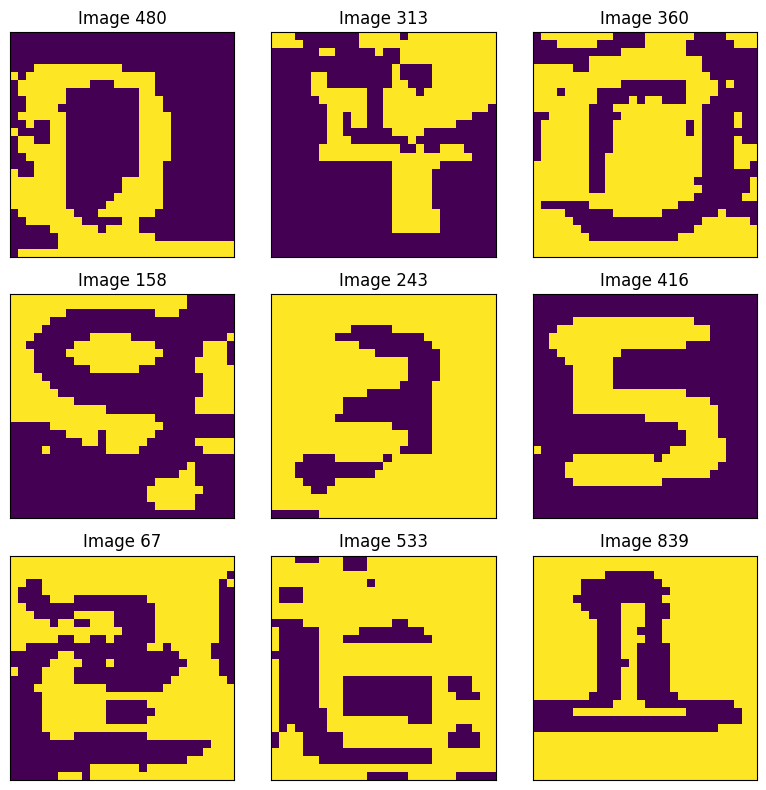

In [21]:
#View Random sample of our dataset after preprocessing 
selected_imgs=Binarized_Images[indices]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(selected_imgs[i])
    ax.set_title(f"Image {indices[i]}")

plt.tight_layout()
plt.show()

In [22]:
#Print the correct labels for the images of the sample
for i in indices:
  print('Image',i ,'Label',label[i])

Image 480 Label 0
Image 313 Label 4
Image 360 Label 0
Image 158 Label 9
Image 243 Label 3
Image 416 Label 5
Image 67 Label 2
Image 533 Label 6
Image 839 Label 1


In [23]:
#Split the images and labels to train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(Binarized_Images, label, test_size=0.2, random_state=42)

In [24]:
#reshape train and test sets 
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1) /1.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1) /1.0

In [25]:
#Create the CNN Model

model = Sequential()
model.add(Conv2D(32, (3, 3),strides=(1, 1), padding='same',activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3),strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3),strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Train the model
model.fit(train_images, train_labels, epochs=10)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

Epoch 1/10
22/22 [==============================] - 12s 15ms/step - loss: 2.2904 - accuracy: 0.1280
Epoch 2/10
22/22 [==============================] - 0s 5ms/step - loss: 2.2510 - accuracy: 0.1878
Epoch 3/10
22/22 [==============================] - 0s 4ms/step - loss: 2.1439 - accuracy: 0.2560
Epoch 4/10
22/22 [==============================] - 0s 4ms/step - loss: 1.7634 - accuracy: 0.4011
Epoch 5/10
22/22 [==============================] - 0s 4ms/step - loss: 1.1974 - accuracy: 0.6174
Epoch 6/10
22/22 [==============================] - 0s 4ms/step - loss: 0.8516 - accuracy: 0.7183
Epoch 7/10
22/22 [==============================] - 0s 4ms/step - loss: 0.5777 - accuracy: 0.8151
Epoch 8/10
22/22 [==============================] - 0s 5ms/step - loss: 0.4923 - accuracy: 0.8236
Epoch 9/10
22/22 [==============================] - 0s 4ms/step - loss: 0.3882 - accuracy: 0.8890
Epoch 10/10
6/6 [==============================] - 0s 25ms/step - loss: 0.3715 - accuracy: 0.9091
Test accuracy: 0.9

In [27]:
#take a random sample of test set
indices = np.random.choice(range(len(test_images)), replace=False, size=10)

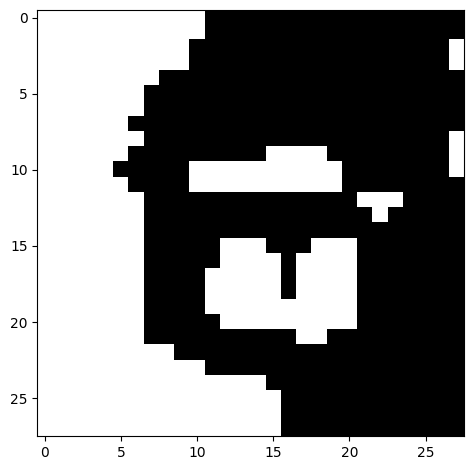

In [28]:
#View an image from test set
io.imshow(test_images[indices[0]]/1.0)

In [29]:
#Print the predicted and Actual results of testset sample
for i in indices:
  predicted_image=test_images[i]
  image_reshaped=np.reshape(predicted_image,[1,28,28])
  input_prediction=model.predict(image_reshaped)
  predicted_label=np.argmax(input_prediction)
  print('Predicted Digit is ',predicted_label, 'Actual Digit is',test_labels[i])

1/1 [==============================] - 0s 177ms/step
Predicted Digit is  6 Actual Digit is 6
1/1 [==============================] - 0s 17ms/step
Predicted Digit is  4 Actual Digit is 4
1/1 [==============================] - 0s 20ms/step
Predicted Digit is  3 Actual Digit is 3
1/1 [==============================] - 0s 18ms/step
Predicted Digit is  3 Actual Digit is 3
1/1 [==============================] - 0s 22ms/step
Predicted Digit is  2 Actual Digit is 2
1/1 [==============================] - 0s 56ms/step
Predicted Digit is  0 Actual Digit is 0
1/1 [==============================] - 0s 91ms/step
Predicted Digit is  3 Actual Digit is 3
1/1 [==============================] - 0s 31ms/step
Predicted Digit is  0 Actual Digit is 0
1/1 [==============================] - 0s 21ms/step
Predicted Digit is  8 Actual Digit is 6
1/1 [==============================] - 0s 19ms/step
Predicted Digit is  0 Actual Digit is 0


In [32]:
save_model(model,'DigitOCR.h5')